In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=.75, style="dark")

## Ett annat sätt att titta på MNIST

Det är förstås rimligt att tänka på MNIST-datan utifrån att varje handskriven siffra är en observation - det är ju så vi tränar modellen.

Ett annat sätt att göra MNIST-datan *tidy* är att tänka på varje *pixel* som en observation. Det är trots allt de enskilda pixlarna som utgör våra *features*.

Vi laddar in en lite annorlunda version av MNIST-datan.

In [53]:
df_wide = pd.read_csv("mnist_train.csv", index_col=False, dtype=int)
# df = df[:300]

In [45]:
df_wide.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df_wide.rename({"0": "label"}, axis=1, inplace=True)
df_wide.insert(1, "instance",  df_wide.index + 1)

In [47]:
df_wide.head()

,label,instance,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


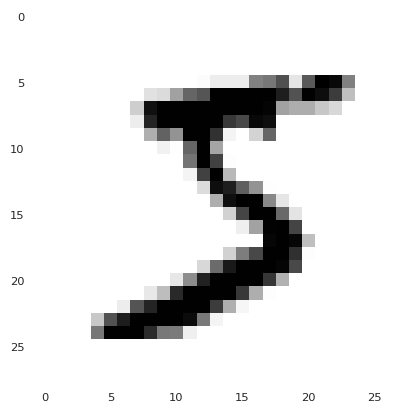

In [48]:
first_instance = df_wide.iloc[0]

plt.imshow(first_instance[2:].values.reshape(28, 28), cmap="binary")


### *Wide* och *long* data 
Vad vi är ute efter är att göra om datan från *wide* till *long*, det vill säga minska antalet kolumner och istället öka antalet rader.

*Notera att vi inte kommer att träna modeller på vårt "långa" dataset - det här är ett sätt för oss att ytterligare lära känna vårt dataset.*

För att formatera vårt dataset från *wide* till *long* använder vi pandas-funktionen `melt()`. Vi anger vilka kolumner vi vill behålla som kolumner, i det här fallet `label` och `instance`. De övriga kolumnerna kommer att slås ihop till en enda kolumn, som vi kallar `pixel`.

In [68]:
df_long = pd.melt(df_wide, id_vars=["label", "instance"], var_name="pixel")
df_long["pixel"] = df_long["pixel"].astype(int)

In [69]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39200 entries, 0 to 39199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   label     39200 non-null  int64
 1   instance  39200 non-null  int64
 2   pixel     39200 non-null  int64
 3   value     39200 non-null  int64
dtypes: int64(4)
memory usage: 1.2 MB


In [70]:
df_long.head()

,label,instance,pixel,value
0,5,1,1,0
1,0,2,1,0
2,4,3,1,0
3,1,4,1,0
4,9,5,1,0


Vi börjar räkna pixlar från 0.

In [71]:
df_long["pixel"] = df_long["pixel"] - 1

In [72]:
df_long.head()

,label,instance,pixel,value
0,5,1,0,0
1,0,2,0,0
2,4,3,0,0
3,1,4,0,0
4,9,5,0,0


Vi behöver varje pixels `x`- och `y`-koordinater.

In [73]:
df_long["x"] = df_long["pixel"] % 28
df_long["y"] = (28 - df_long["pixel"] // 28) - 1

Nu är vi färdiga med att formatera om datan från det breda till det långa formatet.

In [74]:
df_long.head()

,label,instance,pixel,value,x,y
0,5,1,0,0,0,27
1,0,2,0,0,0,27
2,4,3,0,0,0,27
3,1,4,0,0,0,27
4,9,5,0,0,0,27


### EDA på långform-datan

Nu har vi alla pixelvärden samlade i en kolumn, `value`. Vi kan kolla hur de är fördelade.

<Axes: xlabel='value', ylabel='Count'>

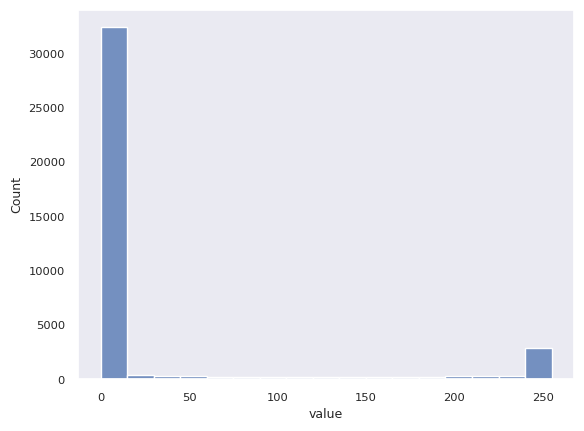

In [75]:
sns.histplot(df_long, x="value")

Det ser ut som om vi skulle kunna ta bort gråskalorna, det vill säga alla pixelvärden mellan 0 och 255.

In [76]:
df_long["value"] = np.where(df_long.value > 127, 1, 0)

<Axes: xlabel='value', ylabel='Count'>

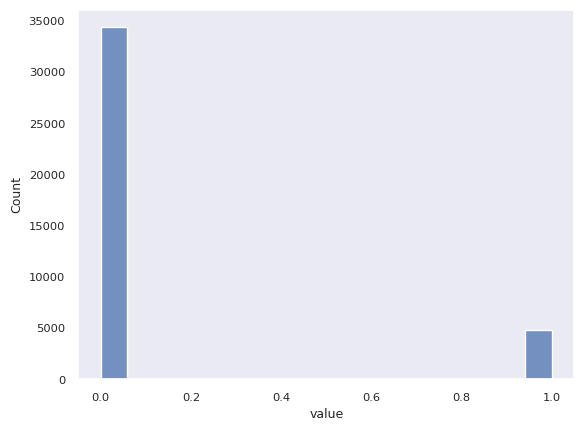

In [77]:
sns.histplot(df_long, x="value")

In [78]:
label_means = df_long.groupby(["x", "y", "label"])["value"].mean().to_frame().reset_index()

In [79]:
label_means.head()

,x,y,label,value
0,0,0,0,0.0
1,0,0,1,0.0
2,0,0,2,0.0
3,0,0,3,0.0
4,0,0,4,0.0


In [80]:
label_means.loc[3500:3510]

,x,y,label,value
3500,12,14,0,0.500000
3501,12,14,1,0.000000
3502,12,14,2,0.000000
3503,12,14,3,0.857143
3504,12,14,4,0.250000
3505,12,14,5,0.500000
3506,12,14,6,0.200000
3507,12,14,7,0.000000
3508,12,14,8,0.750000
3509,12,14,9,0.428571


In [81]:
label_means.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7840 entries, 0 to 7839
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       7840 non-null   int64  
 1   y       7840 non-null   int64  
 2   label   7840 non-null   int64  
 3   value   7840 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 245.1 KB


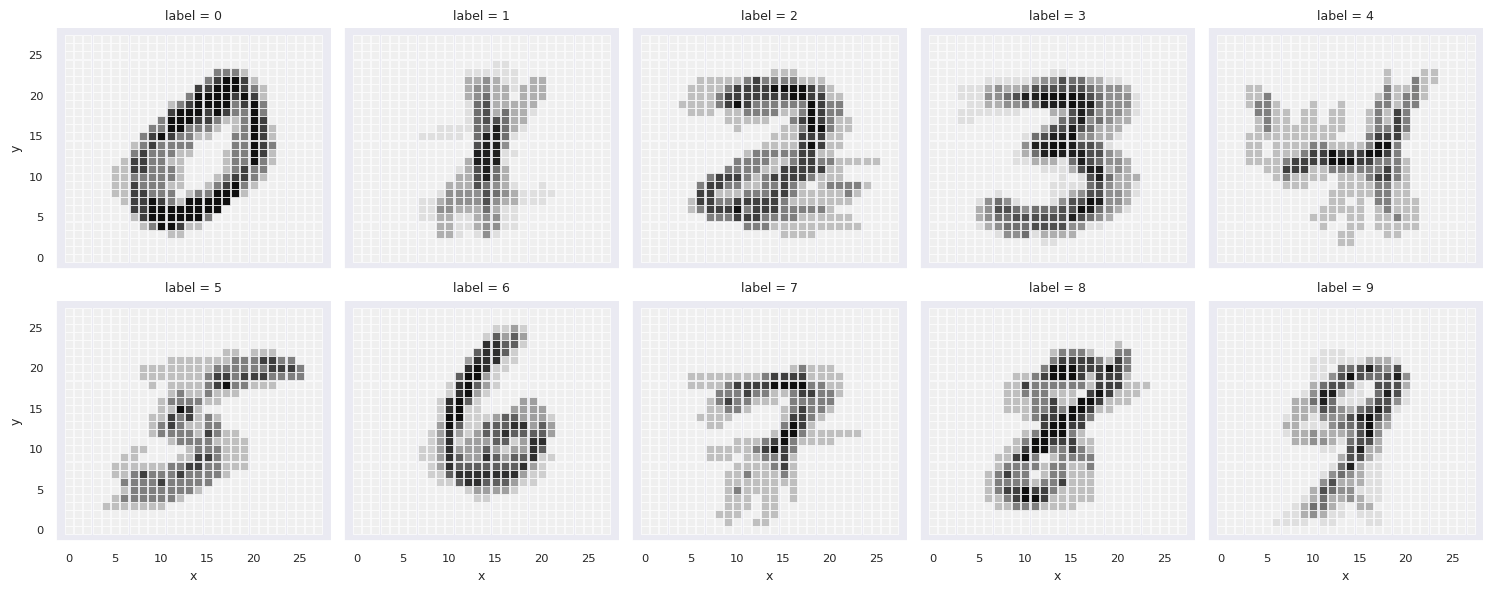

In [86]:
g = sns.FacetGrid(label_means, col="label", hue="value", col_wrap=5, palette="binary")
g.map(sns.scatterplot, "x", "y", marker="s")

In [83]:
first_12 = df_long[df_long.instance <= 12]

In [84]:
first_12

,label,instance,pixel,value,x,y
0,5,1,0,0,0,27
1,0,2,0,0,0,27
2,4,3,0,0,0,27
3,1,4,0,0,0,27
4,9,5,0,0,0,27
...,...,...,...,...,...,...
39157,3,8,783,0,27,0
39158,1,9,783,0,27,0
39159,4,10,783,0,27,0
39160,3,11,783,0,27,0


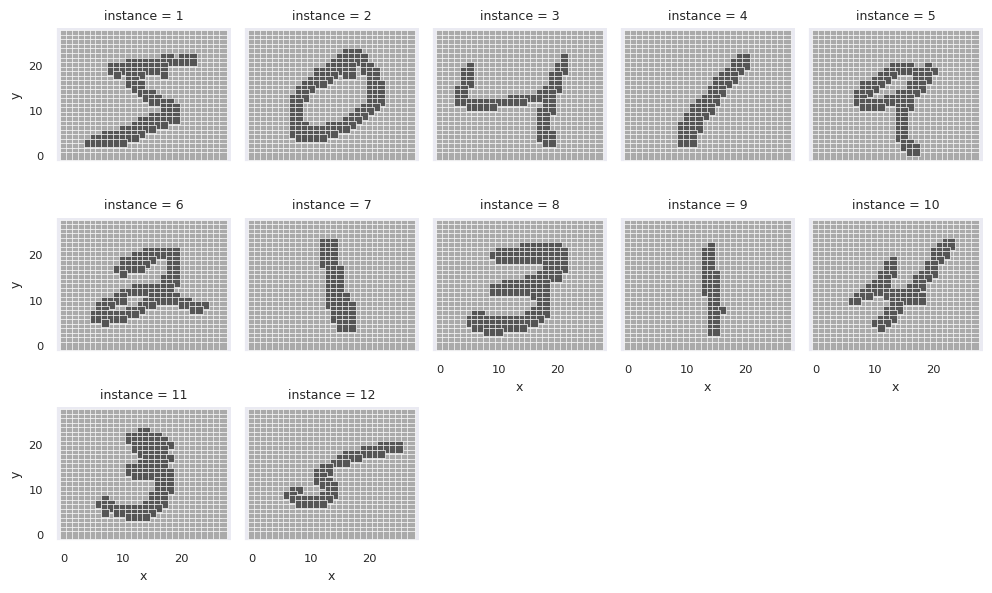

In [87]:
g = sns.FacetGrid(first_12, col="instance", hue="value", col_wrap=5, palette="binary", height=2)
g.map(sns.scatterplot, "x", "y", marker="s")